# MST-GNN model - dynamic approach - Crypto Market

## Import libraries

In [38]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

# Import your custom modules
# If these fail, ensure the .py files are in the same folder as this notebook
from models.MST import MST_GNN
from dataset import InMemoryDynamicSP100
from models.train import train

# Setup Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cuda


## Setting hyper parameters

In [39]:
# Data Configuration
PAST_WINDOW = 30       # Look-back window (Delta t)
FUTURE_WINDOW = 1      # Prediction horizon
BATCH_SIZE = 32

# MSCMG Graph Generation Params
GRAPH_RETURN_THRESH = 0.01  # 1% movement threshold (increased from 0.0009 - was TOO sparse)
LABEL_RETURN_THRESH = 0.013  # 2% movement threshold for labels
MAX_DIST = 7           # Max Manhattan distance for edges (reduced from 8 to be more selective)

# Model Configuration
INPUT_FEATURES = 9     # Check your values.csv (e.g., Open, Close, High, Low...)
HIDDEN_SIZE = 64
GRAPH_LAYERS = 3       # 'M' layers
CROSS_LAYERS = 2       # 'C' layers
LEARNING_RATE = 0.001  # Increased from 0.0005 to speed up convergence

NUM_EPOCHS = 100

## Loading data

In [40]:
print("Initializing Dataset...")

# We set force_process=True to regenerate with new 3-class labels
# After first run, you can set it back to False to load from disk
dataset = InMemoryDynamicSP100(
    root="../data",
    values_file_name="values_crypto.csv", 
    past_window=PAST_WINDOW, 
    future_window=FUTURE_WINDOW,
    graph_return_threshold=GRAPH_RETURN_THRESH,
    label_return_threshold=LABEL_RETURN_THRESH,
    max_dist_threshold=MAX_DIST,
    force_process=True  # Set to True to regenerate with 3-class labels
)

print(f"Total Samples: {len(dataset)}")
print(f"Feature Shape (Node, Time, Feat): {dataset[0].x.shape}")
print(f"Sample Label (should be 0, 1, or 2): {dataset[0].y}")

Initializing Dataset...
Force reload: Deleted old processed file.
Processing Dynamic Graphs (MSCMG)...
Loading raw data from: ../data/raw/values_crypto.csv
Detected: 50 Stocks, 1058 Days, 14 Features


Processing...


Successfully reshaped data to: (50, 1058, 14)
Processed 0/1027 time steps...
Processed 100/1027 time steps...
Processed 200/1027 time steps...
Processed 300/1027 time steps...
Processed 400/1027 time steps...
Processed 500/1027 time steps...
Processed 600/1027 time steps...
Processed 700/1027 time steps...
Processed 800/1027 time steps...
Processed 900/1027 time steps...
Processed 1000/1027 time steps...
Done! Saved processed data to ../data/processed/sp100_dynamic_mscmg.pt
Total Samples: 1027
Feature Shape (Node, Time, Feat): torch.Size([50, 30, 14])
Sample Label (should be 0, 1, or 2): tensor([1, 0, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0,
        0, 1])


Done!


## Preprocessing data

In [41]:
train_part = 0.8
train_dataset = dataset[:int(train_part * len(dataset))]
test_dataset =  dataset[int(train_part * len(dataset)):]

print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

Train dataset: 821, Test dataset: 206


## Model Setting

In [42]:
# 1. Get the actual feature count from the loaded dataset
# dataset[0].x is shape (Nodes, Time, Features) -> We want index 2
REAL_INPUT_FEATURES = dataset[0].x.shape[2] 
print(f"Dataset has {REAL_INPUT_FEATURES} features.")

# 2. Initialize Model with the CORRECT size
model = MST_GNN(
    in_features=REAL_INPUT_FEATURES, # <--- Use the dynamic value here!
    hidden_size=HIDDEN_SIZE,
    num_graph_layers=GRAPH_LAYERS,
    num_cross_layers=CROSS_LAYERS
).to(DEVICE)

print("Model initialized with correct input dimensions.")

Dataset has 14 features.
Model initialized with correct input dimensions.


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training 

In [44]:

print(f"Training on {len(train_dataset)} samples, Testing on {len(test_dataset)} samples.")
print("3-Class Classification: 0=Downward, 1=Neutral, 2=Upward")

# 3. Run the Training Loop
# Ensure you have the 'train' function defined from our previous step
print("Starting training with loss tracking...")
train_losses_epoch, test_losses_epoch = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=NUM_EPOCHS,             # Adjust epochs as needed
    task_title="MST_GNN_Run_1",
    measure_acc=True
)
print("Training complete!")

Training on 821 samples, Testing on 206 samples.
3-Class Classification: 0=Downward, 1=Neutral, 2=Upward
Starting training with loss tracking...


Epochs: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s, Batch=100.0%]

Training complete!


In [45]:
from datetime import datetime

# Generate timestamp for model filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"../runs/mst_dynamic_crypto_{model.__class__.__name__}_{timestamp}.pt"

# Save model
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../runs/mst_dynamic_crypto_MST_GNN_20260124_002318.pt


## Visualizing results

Plot saved to: ../runs/mst_dynamic_crypto_MST_GNN_20260124_002318_predictions.png


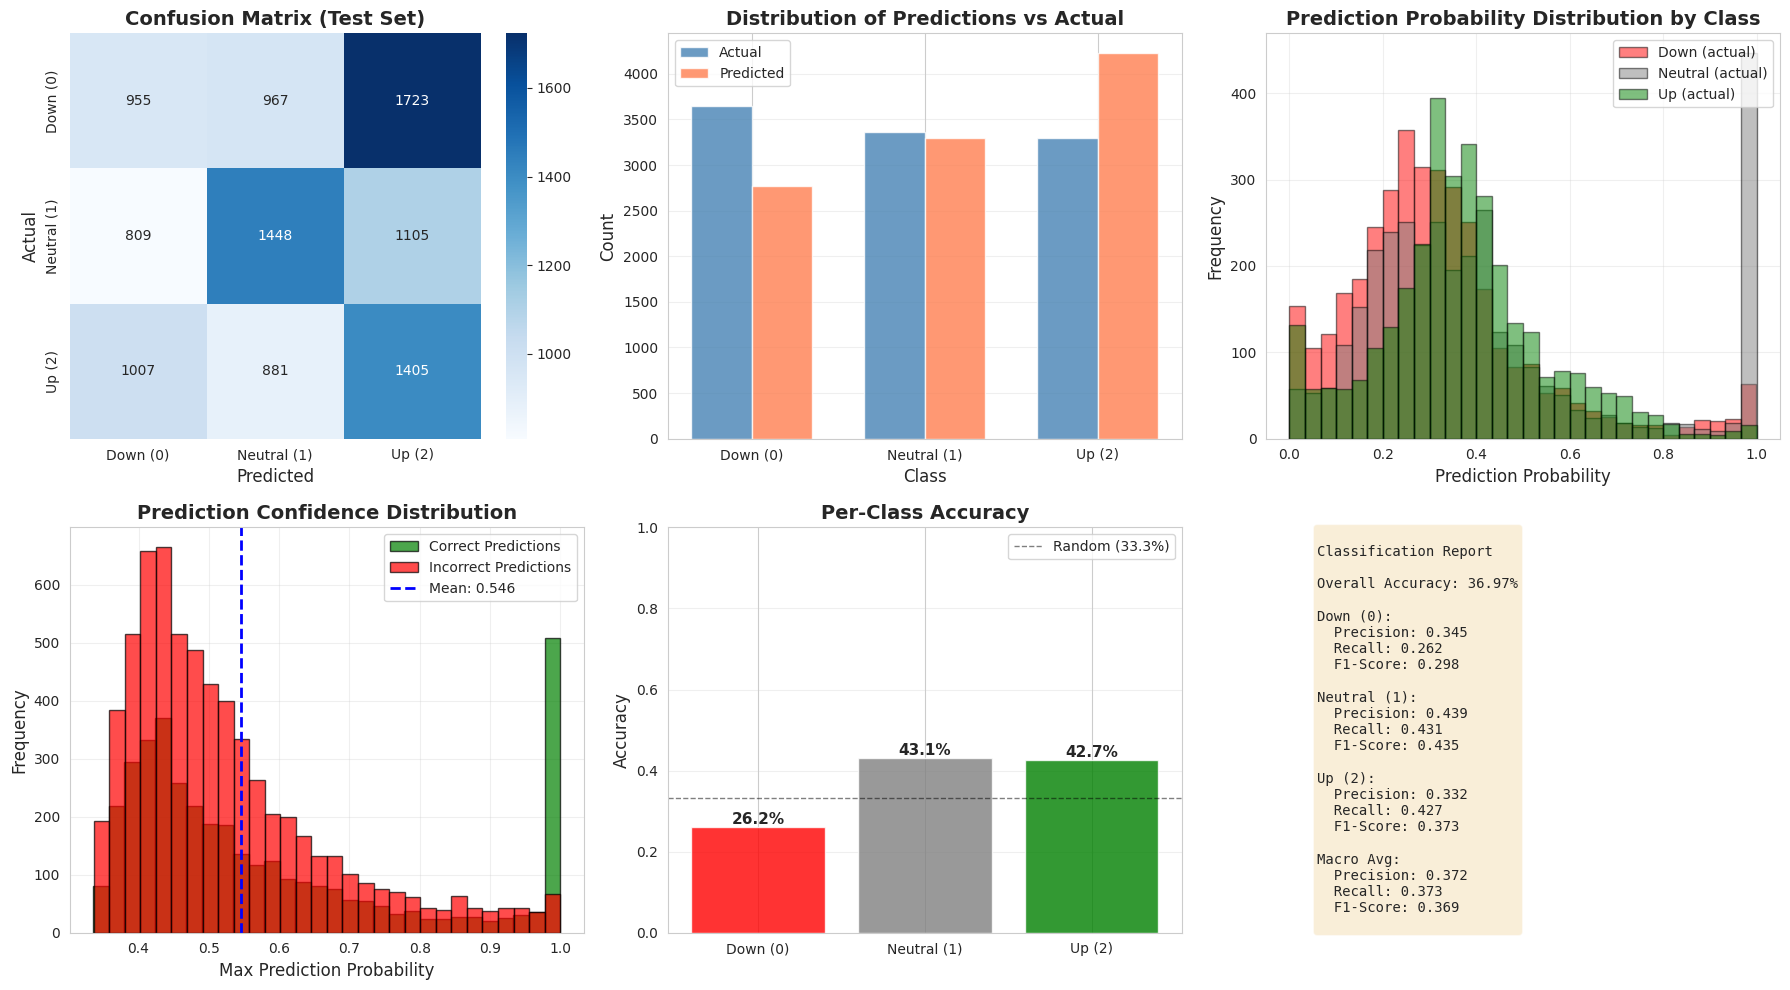


PREDICTION VISUALIZATION SUMMARY
Total predictions: 10300
Overall accuracy: 36.97%

Class Distribution (Actual):
  Down (0):    3645 (35.39%)
  Neutral (1):  3362 (32.64%)
  Up (2):      3293 (31.97%)

Class Distribution (Predicted):
  Down (0):    2771 (26.90%)
  Neutral (1):  3296 (32.00%)
  Up (2):      4233 (41.10%)

Average max prediction probability: 0.546



In [46]:
from visualization_mst import plot_model_predictions

# Visualize model predictions on test set and save the plot
plot_model_predictions(model, test_dataloader, device=DEVICE, save_path=model_path)